# Problem 2: MNIST: Hand-written digit classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
type(train_dataset[0][0])

torch.Tensor

In [ ]:
print(len(train_dataset), len(test_dataset))
print(type(train_dataset[0][0]), train_dataset[0][0].shape)

48000 10000
<class 'torch.Tensor'> torch.Size([1, 28, 28])


We can convert images to numpy arrays and plot them with matplotlib:

6


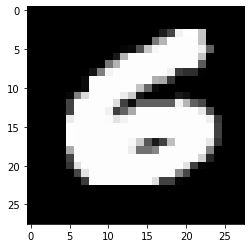

In [ ]:
print(train_dataset[0][1])
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

**train_dataset contains 48,000 images. train_dataset[0] will return the an object associated with the first image. train_dataset[0][0] is a tensor of size 1x28x28 (each image has 1 channel and is of size 28x28 pixels). train_dataset[0][0][0] is the actual image (have to index into the channel). train_dataset[0][1] is the label of the image (e.g. if the first image is a 6 then train_dataset[0][1] = 6).**

**test_dataset contains 10,000 images.**

## Example linear model
Let's instantiate a linear model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # For fully-connected networks, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 10),
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


## Training and validation

Now let's try to train the linear model as an example.

In [ ]:
def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

    # We could write our training procedure manually and directly index the `Dataset` objects,
    # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    valid_accuracy_history = np.zeros([n_epochs, 1])
    valid_loss_history = np.zeros([n_epochs, 1])

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                valid_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history[epoch] = valid_loss / len(valid_loader.dataset)
        valid_accuracy_history[epoch] = correct / len(valid_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (valid_loss_history[epoch], correct, len(valid_loader.dataset),
              100. * valid_accuracy_history[epoch]))
    
    return model, train_loss_history, valid_loss_history, valid_accuracy_history

Train Epoch: 1  Average loss: 0.0154
Valid set: Average loss: 0.0108, Accuracy: 10860/12000 (90.5000)

Train Epoch: 2  Average loss: 0.0097
Valid set: Average loss: 0.0099, Accuracy: 10924/12000 (91.0333)

Train Epoch: 3  Average loss: 0.0089
Valid set: Average loss: 0.0095, Accuracy: 10985/12000 (91.5417)

Train Epoch: 4  Average loss: 0.0085
Valid set: Average loss: 0.0095, Accuracy: 10996/12000 (91.6333)

Train Epoch: 5  Average loss: 0.0083
Valid set: Average loss: 0.0093, Accuracy: 11006/12000 (91.7167)

Train Epoch: 6  Average loss: 0.0081
Valid set: Average loss: 0.0093, Accuracy: 11002/12000 (91.6833)

Train Epoch: 7  Average loss: 0.0080
Valid set: Average loss: 0.0093, Accuracy: 10996/12000 (91.6333)

Train Epoch: 8  Average loss: 0.0079
Valid set: Average loss: 0.0093, Accuracy: 11024/12000 (91.8667)

Train Epoch: 9  Average loss: 0.0078
Valid set: Average loss: 0.0093, Accuracy: 11000/12000 (91.6667)

Train Epoch: 10  Average loss: 0.0077
Valid set: Average loss: 0.0091, Ac

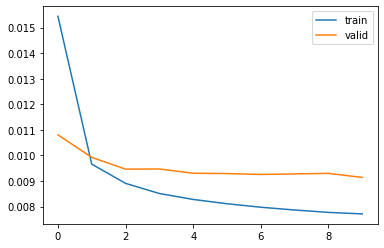

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

## Testing
After selecting hyperparameters from the validation set, evaluate on the held-out test set (distinct from the validation set).

In [ ]:
def test_performance(model, batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    # Putting layers like Dropout into evaluation mode
    model.eval()
    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
          100. * test_accuracy))
    return test_loss, test_accuracy

In [ ]:
test_performance(model)

Test set: Average loss: 0.0084, Accuracy: 9267/10000 (92.6700)


(0.008358465664833784, 0.9267)

Not bad! Even the linear model gets above 92% accuracy.

## Visualizing predictions

We can visualize and inspect the model predictions. Here is an example of how to visualize the wrongly classified cases among the first 20 validation examples.

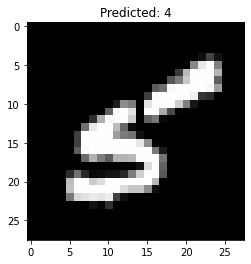

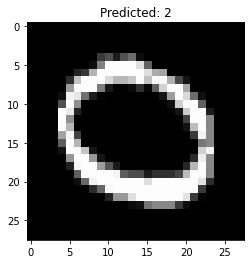

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

# Turning off automatic differentiation
with torch.no_grad():
      for i in range(20):
        data, target = valid_dataset[i]
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        if pred.item() != target:
            plt.imshow(data[0].numpy(), cmap='gray')
            plt.title(f'Predicted: {pred.item()}')
            plt.show()

# Your code: 2 (b)

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    # TODO
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(200, 10),
    #nn.ReLU(),
    #nn.Dropout(0.70),
    #nn.Linear(70, 50),
    #nn.ReLU(),
    #nn.Linear(50, 10)
    # the nn.CrossEntropyLoss (called in run_training_loop) has a softmax, so not implementing one here
)


Train Epoch: 1  Average loss: 0.0035
Valid set: Average loss: 0.0018, Accuracy: 11373/12000 (94.7750)

Train Epoch: 2  Average loss: 0.0022
Valid set: Average loss: 0.0014, Accuracy: 11513/12000 (95.9417)

Train Epoch: 3  Average loss: 0.0018
Valid set: Average loss: 0.0012, Accuracy: 11564/12000 (96.3667)

Train Epoch: 4  Average loss: 0.0016
Valid set: Average loss: 0.0011, Accuracy: 11608/12000 (96.7333)

Train Epoch: 5  Average loss: 0.0016
Valid set: Average loss: 0.0012, Accuracy: 11592/12000 (96.6000)

Train Epoch: 6  Average loss: 0.0015
Valid set: Average loss: 0.0011, Accuracy: 11645/12000 (97.0417)

Train Epoch: 7  Average loss: 0.0014
Valid set: Average loss: 0.0012, Accuracy: 11607/12000 (96.7250)

Train Epoch: 8  Average loss: 0.0014
Valid set: Average loss: 0.0011, Accuracy: 11665/12000 (97.2083)

Train Epoch: 9  Average loss: 0.0013
Valid set: Average loss: 0.0011, Accuracy: 11672/12000 (97.2667)

Train Epoch: 10  Average loss: 0.0012
Valid set: Average loss: 0.0011, Ac

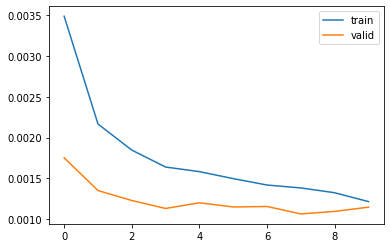

Test set: Average loss: 0.0031, Accuracy: 9750/10000 (97.5000)


(0.0031079366430232765, 0.975)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model, 100, 10, 0.005)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

Documentation:


*   tried 1 hidden layer (Linear(784, 100) -> ReLU -> Dropout(0.1) -> Linear(100, 10) -> ReLU), 10 epochs, batch_size = 32, lr = 1e-3. Got HORRENDOUS results: at 10th epoch valid set had average loss 0.0235, accuracy 69%.
*   Ok then I removed the ReLU from the last layer and also got rid of Dropout. Now I have Linear(784, 100) -> ReLU -> Linear(100, 10), 10 epochs, batch_size = 32, lr = 1e-3. Got much better results: test set avg. loss was .0027, accuracy = 97.420. Almost at 97.5!
*   RIP okay then I did the same as above but with Linear(784, 100) -> ReLU -> Linear(100, 50) -> ReLU -> Linear(50, 10) and got a test set avg. loss of .0039 and accuracy = 96.8. Hmmm...
*   Got over the 97.5 threshold! Doing Linear(784, 100) -> ReLU -> Linear(100, 50) -> ReLU -> Dropout(0.1) -> Linear(50, 30) -> ReLU -> Linear(30, 10), 10 epochs, batch_size = 32, lr = 2e-3 got a test set avg. loss of .0033 and accuracy = 97.76.
*   Changing batch_size to 40 took test accuracy to 97.82.
*   But then I ran the exact same code again and the accuracy slipped to 97.46. So I started experimenting again.
*   I tried a shallower network based off of Piazza discussions--I put all 200 weights in one hidden layer. Then I ramped up the batch size to 100, increased the learning rate and set Dropout = 50. This didn't actually do a whole lot better--but it got me to exactly 97.5 and now I am not running this code again less the accuracy slips.





# Example code for convolutional neural networks

In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(8,8)),
    nn.ReLU(),
    nn.MaxPool2d(8),
    nn.Dropout(p=0.5),
    
    nn.Flatten(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

# take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)


# our model has some # of parameters:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

torch.Size([8, 1, 8, 8])
torch.Size([8])
torch.Size([64, 32])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
total params: 3282


Train Epoch: 1  Average loss: 0.0360
Valid set: Average loss: 0.0166, Accuracy: 10312/12000 (85.9333)

Train Epoch: 2  Average loss: 0.0247
Valid set: Average loss: 0.0125, Accuracy: 10725/12000 (89.3750)

Train Epoch: 3  Average loss: 0.0225
Valid set: Average loss: 0.0111, Accuracy: 10824/12000 (90.2000)

Train Epoch: 4  Average loss: 0.0215
Valid set: Average loss: 0.0103, Accuracy: 10898/12000 (90.8167)

Train Epoch: 5  Average loss: 0.0206
Valid set: Average loss: 0.0096, Accuracy: 10976/12000 (91.4667)

Train Epoch: 6  Average loss: 0.0201
Valid set: Average loss: 0.0098, Accuracy: 10977/12000 (91.4750)

Train Epoch: 7  Average loss: 0.0196
Valid set: Average loss: 0.0096, Accuracy: 10999/12000 (91.6583)

Train Epoch: 8  Average loss: 0.0191
Valid set: Average loss: 0.0098, Accuracy: 11025/12000 (91.8750)

Train Epoch: 9  Average loss: 0.0188
Valid set: Average loss: 0.0093, Accuracy: 11023/12000 (91.8583)

Train Epoch: 10  Average loss: 0.0183
Valid set: Average loss: 0.0091, Ac

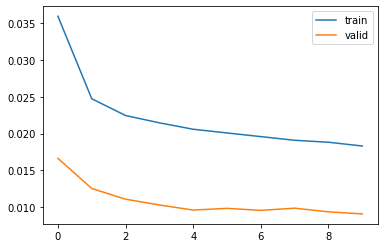

Test set: Average loss: 0.0084, Accuracy: 9235/10000 (92.3500)


(0.00840579897016287, 0.9235)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

## Your code: 2 (c)

In [ ]:
model = nn.Sequential(
    # TODO
    nn.Conv2d(1, 2, kernel_size=(3, 3)),
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 4, (3, 3)),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.Conv2d(4, 8, (5, 5)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 16, (7, 7)),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Dropout(p=0.1),
    
    nn.Flatten(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

# make sure the # of parameters is under 50,000
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

total params: 41438


Train Epoch: 1  Average loss: 0.0022
Valid set: Average loss: 0.0016, Accuracy: 11815/12000 (98.4583)

Train Epoch: 2  Average loss: 0.0015
Valid set: Average loss: 0.0016, Accuracy: 11838/12000 (98.6500)

Train Epoch: 3  Average loss: 0.0013
Valid set: Average loss: 0.0015, Accuracy: 11822/12000 (98.5167)

Train Epoch: 4  Average loss: 0.0011
Valid set: Average loss: 0.0016, Accuracy: 11830/12000 (98.5833)

Train Epoch: 5  Average loss: 0.0010
Valid set: Average loss: 0.0011, Accuracy: 11872/12000 (98.9333)

Train Epoch: 6  Average loss: 0.0009
Valid set: Average loss: 0.0012, Accuracy: 11876/12000 (98.9667)

Train Epoch: 7  Average loss: 0.0008
Valid set: Average loss: 0.0012, Accuracy: 11876/12000 (98.9667)

Train Epoch: 8  Average loss: 0.0008
Valid set: Average loss: 0.0014, Accuracy: 11853/12000 (98.7750)

Train Epoch: 9  Average loss: 0.0006
Valid set: Average loss: 0.0015, Accuracy: 11851/12000 (98.7583)

Train Epoch: 10  Average loss: 0.0006
Valid set: Average loss: 0.0013, Ac

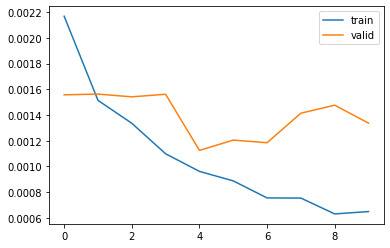

Test set: Average loss: 0.0010, Accuracy: 9906/10000 (99.0600)


(0.0010033370873861714, 0.9906)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model, 32, 10, .002)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

Documentation of what I did along the way
*   First I tried Conv2d(1, 8, 8) -> ReLU -> Conv2d(8, 16, 4) -> ReLU -> Conv2d(16, 32, 8) -> MaxPool2d(4) -> flatten -> Linear(128, 256) -> ReLU -> Linear(256, 10)
*   Then I tried Conv2d(1, 2, 8) -> ReLU -> Conv2d(2, 4, 8) -> ReLU -> MaxPool2d(4) -> flatten -> Linear(36, 64) -> ReLU -> Linear(64, 10)
*   Then I read up on some tips: start with smaller filters and less channels; use 3x3, 5x5 or 7x7 filters for convolutions and 2x2 or 3x3 for pooling, try padding, and keep adding layers till you overfit.
*   Following this, I tried  Conv2d(1, 2, 3) -> ReLU -> Conv2d(2, 4, 3) -> ReLU -> Conv2d(4, 8, 5) -> ReLU -> Conv2d(8, 16, 7) -> ReLU -> MaxPool2d(3) -> flatten -> Linear(256, 128) -> ReLU -> Linear(128, 10).
*   Then I added BatchNorm2d before every ReLU. Got test set accuracy of 99.06!!
*   Citation: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

# Problem 3: Vision Transformer

In [ ]:
!pip install einops

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

## Your code: 3(a)

Implement single-head attention.

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, input_dim, inner_dim, dropout = 0.):
        super().__init__()
        # TODO
        self.q = nn.Linear(input_dim, inner_dim)
        self.k = nn.Linear(input_dim, inner_dim)
        self.v = nn.Linear(input_dim, inner_dim)


    def forward(self, x):
        # TODO
        query = self.q(x)
        key = self.k(x)
        value = self.k(x)

        QKt = torch.matmul(query, torch.transpose(key, 1, 2))
        scaled = QKt / (query.shape[2]**(0.5))
        post_sm_attn_weights = scaled
        print(post_sm_attn_weights)
        m = nn.Softmax(dim=2) # softmax is applied in a weird way
        out = torch.matmul(m(scaled), value)
        return out

Test the following multihead attention implementation that relies on the single-head attention implementation above.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        self.attention_heads = nn.ModuleList([
            SingleHeadAttention(dim, dim_head, dropout=dropout)
            for _ in range(heads)
        ])

    def forward(self, x):
        out = torch.cat([
            head(x) for head in self.attention_heads
        ], dim=-1)
        return out

Test code for multihead attention:

In [ ]:
T = 5
input_dim = 32
batch_size = 20

heads = 8
dim_head = 64

test_input = torch.zeros((batch_size, T, input_dim))

test_attention_module = Attention(input_dim)
test_output = test_attention_module(test_input)

print(test_output)
assert test_output.size() == (batch_size, T, heads * dim_head), "Shapes are incorrect"

tensor([[[-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669]],

        [[-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669]],

        [[-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
         [-0.0630,  0.0488, -0.1473,  ...,  0.0174,  0.1105,  0.0669],
  

In [ ]:
test = torch.zeros((20, 5, 32))

In [ ]:
test.shape[1]

5

## Your code: 3 (b)

In [ ]:
class ViTLayer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.heads = heads
        self.dim_head = dim_head
        self.dim = dim
        self.attn = nn.Sequential(
            # TODO
            nn.LayerNorm(dim),
            Attention(dim, heads, dim_head, dropout),
            nn.Linear(self.heads * self.dim_head, self.dim)
        )
        self.feedforward = nn.Sequential(
            # TODO
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # TODO
        attn = self.attn(x)
        residual = x + attn
        out = self.feedforward(residual)
        return out + residual

## ViT code for 3 (c)

In [ ]:
class ViT(nn.Module):
    def __init__(self, patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128, 
                 dim_head = 64,
                 dropout = 0., emb_dropout = 0.):
        super().__init__()

        image_height, image_width = 28, 28
        num_classes = 10
        channels = 1

        patch_height = patch_size
        patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, (
            'Image dimensions must be divisible by the patch size.')

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.Sequential(*nn.ModuleList([
            ViTLayer(dim, heads, dim_head, mlp_dim, dropout)
            for _ in range(depth)                       
        ]))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.emb_dropout(x)

        x = self.transformer(x)

        x = x[:, 0]
        return self.mlp_head(x)

In [ ]:
model = ViT(patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128)

Train Epoch: 1  Average loss: 0.0117
Valid set: Average loss: 0.0055, Accuracy: 11389/12000 (94.9083)

Train Epoch: 2  Average loss: 0.0047
Valid set: Average loss: 0.0045, Accuracy: 11480/12000 (95.6667)

Train Epoch: 3  Average loss: 0.0036
Valid set: Average loss: 0.0035, Accuracy: 11594/12000 (96.6167)

Train Epoch: 4  Average loss: 0.0032
Valid set: Average loss: 0.0033, Accuracy: 11603/12000 (96.6917)

Train Epoch: 5  Average loss: 0.0028
Valid set: Average loss: 0.0034, Accuracy: 11607/12000 (96.7250)

Train Epoch: 6  Average loss: 0.0025
Valid set: Average loss: 0.0030, Accuracy: 11645/12000 (97.0417)

Train Epoch: 7  Average loss: 0.0022
Valid set: Average loss: 0.0027, Accuracy: 11692/12000 (97.4333)

Train Epoch: 8  Average loss: 0.0020
Valid set: Average loss: 0.0029, Accuracy: 11671/12000 (97.2583)

Train Epoch: 9  Average loss: 0.0019
Valid set: Average loss: 0.0025, Accuracy: 11714/12000 (97.6167)

Train Epoch: 10  Average loss: 0.0017
Valid set: Average loss: 0.0028, Ac

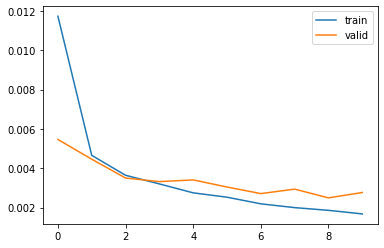

Test set: Average loss: 0.0023, Accuracy: 9771/10000 (97.7100)


(0.002304830387653783, 0.9771)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

Test accuracy is 97.7100 (might have gotten cut off when I printed to PDF).

2


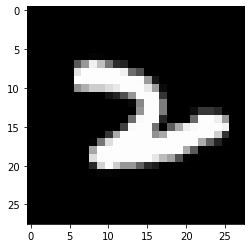

In [ ]:
print(valid_dataset[0][1])
plt.imshow(valid_dataset[0][0][0].numpy(), cmap='gray')

In [ ]:
len(trained_model.transformer)

6

In [ ]:
x = valid_dataset[0][0][0]
#type(x), x.shape
len(valid_dataset)

12000

In [ ]:
test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False) 
print(len(test_loader)) # length 12000, want only the 1st element
for data, target in test_loader:
  print(type(data), data.shape)
  #plt.imshow(data[0][0].numpy(), cmap='gray')
  #output = trained_model(data)
  output = model(data)
  break
# Turning off automatic differentiation
#with torch.no_grad():
 #   for data, target in test_loader:
  #      output = model(data)

12000
<class 'torch.Tensor'> torch.Size([1, 1, 28, 28])


In [ ]:
output.shape

torch.Size([1, 10])

In [ ]:
output

tensor([[-2.5836, -0.4189,  9.5562,  1.4441, -3.4849,  0.7073, -3.4389,  3.5094,
         -4.5024, -2.7769]], grad_fn=<AddmmBackward0>)